In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import tqdm

import sys
sys.path.append("..")

from scripts.Safe import *

In [2]:
def read_tmscore(path):
    with open(path, "r") as f:
        raw = f.read()
        if raw.count("\n") < 2:
            return (None, None, None)

        spl = raw.split("\n")[1].split()
        if spl[0] == "There":
            return (None, None, None)

        tm1 = float(spl[2])
        tm2 = float(spl[3])
        rmsd = float(spl[4])
        return (tm1, tm2, rmsd)

def parse_cluster_name(path):
    return path.split("/")[-4]

def parse_seq_accession(path):
    return path.split("/")[-3]

def read_tms(batch, work_dir, alpha, delta, safe_coverage_threshold=None):
    tms = []
    rmsds = []
    cluster_name = parse_cluster_name(batch[0])
    cluster = Cluster(f"{work_dir}/safety.a{alpha}.d{delta}/{cluster_name}.out")
    for tm_file in tqdm.tqdm(batch):
        _, tm, rmsd = read_tmscore(tm_file)
        if tm == None:
            continue
        if safe_coverage_threshold != None:
            if cluster_name != parse_cluster_name(tm_file):
                cluster_name = parse_cluster_name(tm_file)
                cluster = Cluster(f"{work_dir}/safety.a{alpha}.d{delta}/{cluster_name}.out")
            sc = cluster.get(parse_seq_accession(tm_file)).safe_coverage
            # print(sc)
            # print(cluster_name)
            if sc > safe_coverage_threshold:
                continue

        tms.append(tm)
        rmsds.append(rmsd)

    return (tms, rmsds)

def read_scores(work_dir, alpha, delta, safe_coverage_threshold=None):
    safes = sorted(glob.glob(os.path.join(work_dir, f"tmscore.a{alpha}.d{delta}", "*", "*", "safe", "*.out")))
    unsafes = sorted(glob.glob(os.path.join(work_dir, f"tmscore.a{alpha}.d{delta}", "*", "*", "unsafe", "*.out")))

    print("Reading safes")
    safe_tm, safe_rmsd = read_tms(safes, work_dir, alpha, delta, safe_coverage_threshold)
    print("Reading non-safes")
    unsafe_tm, unsafe_rmsd = read_tms(unsafes, work_dir, alpha, delta, safe_coverage_threshold)

    safe_df = pd.DataFrame(data={"tm":safe_tm, "rmsd": safe_rmsd})
    unsafe_df = pd.DataFrame(data={"tm":unsafe_tm, "rmsd": unsafe_rmsd})
    return (safe_df, unsafe_df)

In [3]:
def read_groups(path, alphas, deltas, safe_coverage_th=None):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            groups[(alpha, delta)] = read_scores(path, alpha, delta, safe_coverage_th)
    return groups

alphas = [75, 99]
deltas = [8,10,15]

groups = read_groups("./../out/clusters100.20.multi-step/", alphas, deltas, 0.4)


Reading safes


100%|██████████| 242039/242039 [00:47<00:00, 5123.31it/s]


Reading non-safes


100%|██████████| 43886/43886 [00:19<00:00, 2303.19it/s]


Reading safes


100%|██████████| 248308/248308 [00:51<00:00, 4795.81it/s]


Reading non-safes


100%|██████████| 55475/55475 [00:21<00:00, 2525.78it/s]


Reading safes


100%|██████████| 252974/252974 [00:32<00:00, 7853.59it/s] 


Reading non-safes


100%|██████████| 79331/79331 [00:17<00:00, 4446.02it/s]


Reading safes


100%|██████████| 160429/160429 [00:21<00:00, 7596.30it/s]


Reading non-safes


100%|██████████| 83774/83774 [00:13<00:00, 6083.76it/s]


Reading safes


100%|██████████| 108972/108972 [00:13<00:00, 8204.68it/s]


Reading non-safes


100%|██████████| 64619/64619 [00:09<00:00, 7110.85it/s]


Reading safes


100%|██████████| 174833/174833 [00:23<00:00, 7295.43it/s]


Reading non-safes


100%|██████████| 132487/132487 [00:18<00:00, 7083.59it/s]


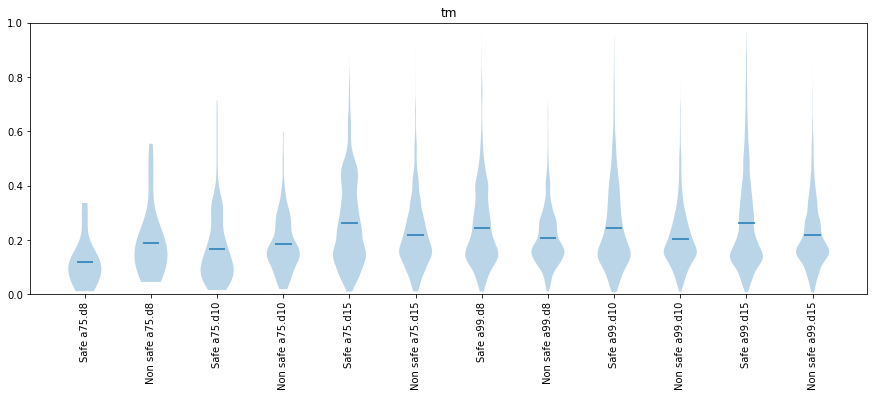

In [15]:
def boxplot(groups, alphas, deltas, features):
    fig, ax = plt.subplots(nrows=len(features), figsize=(15, 5))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                df1 = groups[(a, d)][0]
                df2 = groups[(a, d)][1]
                vals.append(df1[f].values)
                vals.append(df2[f].values)
                labels.append(f"Safe a{a}.d{d}")
                labels.append(f"Non safe a{a}.d{d}")

        if len(features) < 2:
            ax.violinplot(vals, showmeans=True, showextrema=False)
            ax.set_xticks(list(range(1,13)))
            ax.set_xticklabels(labels, rotation=90)
            ax.set_title(f)
            if f != "rmsd":
                ax.set_ylim([0,1])
        else:
            ax[i].violinplot(vals, showmeans=True, showextrema=False)
            ax[i].set_xticks(list(range(1,13)))
            ax[i].set_xticklabels(labels, rotation=90)
            # ax[i].set_title(f)
            if f != "rmsd":
                ax[i].set_ylim([0,1])
        
    plt.show()

boxplot(groups, alphas, deltas, ["tm"])